In [27]:
import json
import os
import math
import numpy as np
import pandas as pd
import yfinance as yf
from dateutil.relativedelta import relativedelta
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm


class global_singal_factor_protfolio():
    def __init__(self, periods=1, weight=[1], tag=['COUNTRY'], factors=['avg_sent']):
        self.periods = periods
        self.weight = weight
        self.tag = tag
        self.factors = factors
        self.path = os.path.abspath('.')
        # self.start_time = dt.datetime(year=2004, month=5, day=31, hour=23, minute=59, second=59)
        # self.end_time = dt.datetime(year=2023, month=1, day=28, hour=23, minute=59, second=59)
        #
        self.length = 224
        # self.length = 80
        #
        # self.time_line = [self.start_time + i * relativedelta(months=1) for i in range(self.length + 1)]
        self.time_line = pd.date_range(start='2004-05-31', freq='M', periods=self.length + 1)
        self.group_number = 5
        self.period_return = np.zeros((self.group_number ** len(self.factors), self.length))
        self.number = np.zeros((self.group_number ** len(self.factors), self.length))
        self.total_return = None
        self.equity = None
        self.ls_period_return = None
        self.ls_total_return = None
        self.ls_equity = None
        self.quantile_evaluation = {}
        self.ls_evaluation = {}

        # self.data = pd.read_csv("Factors.csv")
        # self.columns = self.data.columns
        # self.data["FILING_DATE"] = pd.to_datetime(self.data["FILING_DATE"])
        self.data = pd.read_csv("Factors.csv", parse_dates=["FILING_DATE"])
        self.data = self.data[["TRADINGITEMID", "FILING_DATE"] + self.tag + self.factors]
        self.columns = self.data.columns
        id_in_data = self.data["TRADINGITEMID"].unique().tolist()
        self.stock_price, self.valid_id = self._split(id_in_data)
        # data: "TRADINGITEMID", "FILING_DATE", tag, factors
        # stock_price: "TRADINGITEMID", "PRICEDATE", "ADJ_OPEN", "ADJ_CLOSE"

        self.benchmark_timeline, self.benchmark_pct_change = self._get_benchmark(start=self.time_line[0],
                                                                                 end=self.time_line[-1])
        self.rf = 0.015

    def run(self):
        self.backtest()
        self.alignment()

        self.total_return = (self.period_return + 1).cumprod(axis=1)
        self.equity = 1 * self.total_return

        self.ls_period_return = self.period_return[0, :] - self.period_return[-1, :]
        self.ls_total_return = (self.ls_period_return + 1).cumprod(axis=0)
        self.ls_equity = 1 * self.ls_total_return

        self.annual_return()
        self.sharp_ratio()
        self.alpha()
        self.drawdown()
        self.draw()

    def backtest(self):
        base_index = 2 + len(self.tag)
        data_list = self._get_divided_list()
        for time in range(self.periods, self.length - 1):
            print('time:', time)
            stock_number = np.zeros((self.group_number ** len(self.factors)))
            pct_return = np.zeros((self.group_number ** len(self.factors)))
            # open_price = np.zeros((5))
            # close_price = np.zeros((5))
            # time_nodes = self.time_line[time - self.periods:time + 1]
            for data in data_list:
                stock_pool = []
                for i in range(self.periods):
                    start = self.time_line[time - i - 1]
                    end = self.time_line[time - i]
                    mask1 = data[:, 1] > start
                    mask2 = data[:, 1] <= end
                    selected_data = data[mask1 & mask2, :]
                    selected_data[:, base_index:] = selected_data[:, base_index:] * self.weight[i]
                    if len(stock_pool) == 0:
                        stock_pool = selected_data
                    else:
                        stock_pool = np.row_stack((stock_pool, selected_data))
                if len(stock_pool) < 50:
                    continue
                with_price = []
                return_list = []
                id_list = []
                for index in range(len(stock_pool)):
                    if stock_pool[index, 0] in self.valid_id and not stock_pool[index, 0] in id_list:
                        id_list.append(stock_pool[index, 0])
                        price = self.stock_price[str(stock_pool[index, 0])]
                        if self.time_line[time + 1] < price[0, 1]:
                            with_price.append(False)
                            continue
                        elif self.time_line[time] > price[-1, 1]:
                            with_price.append(False)
                            continue

                        # info = price[price[:,1]==self.time_line[time+1]]
                        info = price[price[:, 1] > self.time_line[time]]
                        info = info[info[:, 1] <= self.time_line[time + 1]]
                        if len(info) > 0 and info[0, 3] > 0.01 and info[0, 2] > 0.01 and info[0, 2] != info[0, 3]:
                            r = info[0, 3] / info[0, 2] - 1
                            if np.isnan(r):
                                with_price.append(False)
                            else:
                                with_price.append(True)
                                return_list.append(r)
                        else:
                            with_price.append(False)
                    else:
                        with_price.append(False)
                if len(return_list) < 50:
                    continue
                stock_pool = np.column_stack((stock_pool[with_price], np.array(return_list)))
                grouped_by_factor = [stock_pool]
                for j in range(len(self.factors)):
                    new_grouped_result = []
                    for group in grouped_by_factor:
                        group = group[np.argsort(group[:, base_index + j]), :]
                        gap = int(len(group) / self.group_number)
                        for n in range(self.group_number - 1):
                            new_grouped_result.append(group[n * gap:(n + 1) * gap, :])
                        new_grouped_result.append(group[(self.group_number - 1) * gap:, :])
                    grouped_by_factor = new_grouped_result
                1
                for m in range(self.group_number ** len(self.factors)):
                    stock_number[m] = stock_number[m] + len(grouped_by_factor[m])
                    pct_return[m] = pct_return[m] + np.sum(grouped_by_factor[m][:, -1])
            if np.sum(stock_number) == 0:
                self.period_return[:, time] = pct_return
            else:
                self.period_return[:, time] = pct_return / stock_number
                self.number[:, time] = stock_number
            if max(self.period_return[:, time]) > 0.3:
                print(self.time_line[time])
                print(pct_return)
                print(stock_number)

    def alignment(self):
        #  remove 0
        start_index = 0
        end_index = self.length
        self.time_line = self.time_line[1:]  # match time_line with return
        for i in range(self.length - 1):
            if self.number[0, i] == 0 and self.number[0, i + 1] > 0:
                start_index = i + 1  # the first period with valid portfolio
                break
        for i in range(self.length - 1, -1, -1):
            if self.number[0, i] == 0 and self.number[0, i - 1] > 0:
                end_index = i  # the last period with valid portfolio
                break
        self.time_line = self.time_line[start_index:end_index]
        self.number = self.number[:, start_index:end_index]
        self.period_return = self.period_return[:, start_index:end_index]

        # align data with benchmark
        start_time = self.time_line[0] if self.time_line[0] >= self.benchmark_timeline[0] else self.benchmark_timeline[
            0]
        end_time = self.time_line[-1] if self.time_line[-1] <= self.benchmark_timeline[-1] else self.benchmark_timeline[
            -1]
        mask1 = self.time_line >= start_time
        mask2 = self.time_line <= end_time
        # mask = (mask1+mask2)>1
        self.time_line = self.time_line[mask1 & mask2]
        self.number = self.number[:, mask1 & mask2]
        self.period_return = self.period_return[:, mask1 & mask2]
        mask1 = self.benchmark_timeline >= start_time
        mask2 = self.benchmark_timeline <= end_time
        # mask = (mask1+mask2)>1
        self.benchmark_pct_change = self.benchmark_pct_change[mask1 & mask2]

    def annual_return(self):
        t = len(self.time_line)/12
        qar = (self.total_return[:, -1]) ** (1 / t) - 1
        self.quantile_evaluation['annual return'] = qar
        lsar = (self.ls_total_return[-1]) ** (1 / t) - 1
        self.ls_evaluation['annual return'] = lsar

    def sharp_ratio(self):
        qsigma = np.std(self.period_return, axis=1) * np.sqrt(12)
        lssigma = np.std(self.ls_period_return) * np.sqrt(12)
        qsharp = (self.quantile_evaluation['annual return'] - self.rf) / qsigma
        lssharp = (self.ls_evaluation['annual return'] - self.rf) / lssigma
        self.quantile_evaluation['sharp ratio'] = qsharp
        self.ls_evaluation['sharp ratio'] = lssharp

    def alpha(self):
        qalpha=[]
        qpvalue = []
        n = self.group_number ** len(self.factors)
        for i in range(n):
            y = pd.DataFrame(self.period_return[i,:]-self.rf,columns=['y'])
            x = pd.DataFrame(self.benchmark_pct_change-self.rf,columns=['x'])
            x = sm.add_constant(x)
            res = sm.OLS(y, x).fit()
            # print(res.params)
            # print(res.pvalues)
            qalpha.append(res.params[0])
            qpvalue.append(res.pvalues[0])
        self.quantile_evaluation['alpha']=qalpha
        self.quantile_evaluation['p-value of alpha'] = qpvalue

        y = pd.DataFrame(self.ls_period_return - self.rf, columns=['y'])
        x = pd.DataFrame(self.benchmark_pct_change - self.rf, columns=['x'])
        x = sm.add_constant(x)
        res = sm.OLS(y, x).fit()
        # print(res.params)
        # print(res.pvalues)
        lsalpha=res.params[0]
        lspvalue=res.pvalues[0]
        self.ls_evaluation['alpha'] = lsalpha
        self.ls_evaluation['p-value of alpha'] = lspvalue

    def drawdown(self):
        dd = []
        n = self.group_number ** len(self.factors)
        for i in range(n):
            dd.append(self._get_drawdowm(self.equity[i,:]))
        self.quantile_evaluation['drawdown'] = dd

        self.ls_evaluation['drawdown'] = self._get_drawdowm(self.ls_equity)

    def draw(self):
        plt.figure()
        for o in range(len(self.equity)):
            plt.plot(self.time_line, self.equity[o, :], label=str(o + 1) + 'th quantile')
        plt.plot(self.time_line,(self.benchmark_pct_change+1).cumprod(),label='benchmark')
        plt.plot(self.time_line,self.ls_equity,label='L/S')
        plt.title(str(portfolio.factors[0]) + "_" + str(portfolio.tag[0]) + "_" + str(portfolio.periods) + "month_weight:" + str(self.weight))
        plt.legend()
        # plt.savefig("./data/"+str(portfolio.factors[0])+""+str(portfolio.tag[0])+""+str(portfolio.periods)+"month"+".png")
        plt.show()
        plt.figure()
        plt.scatter(self.time_line, self.number[0, :], label='stock_number')
        plt.title(str(portfolio.factors[0]) + "_" + str(portfolio.tag[0]) + "_" + str(portfolio.periods))
        plt.legend()
        # plt.savefig("./data/"+str(portfolio.factors[0])+""+str(portfolio.tag[0])+""+str(portfolio.periods)+"month1"+".png")
        plt.show()

    # _________________________________________________________________________________________
    def _get_divided_list(self):
        divided_list = [self.data]
        for t in self.tag:
            comb = []
            for data in divided_list:
                _, tag_dict, tag_dict_note = self._classify(data, t, self.path, if_save=False)
                tag_with_few_samples = tag_dict_note[t + "_with_few_samples"]
                for key in tag_dict:
                    if key in tag_with_few_samples:
                        pass
                    else:
                        # comb.append(np.array(tag_dict[key]))
                        comb.append(pd.DataFrame(tag_dict[key], columns=self.columns))
            divided_list = comb
        divided_list = [df.values for df in divided_list]
        return divided_list

    def _classify(self, data, classification_tag, path, if_save=True):
        """
        Use a specific tag to split data and save the results
        :param data: pd.DataFrame: raw data
        :param classification_tag: str: "SECTOR"  "REGION"  "COUNTRY"
        :param path: str: the absolute path to save results
        :param if_save: Bool: weather save the result or not
        :return: data_with_tag: pd.DataFrame, tag_dict: dict, tag_dict_note: dict
        """

        if classification_tag == None:
            return 0

        #  split by tag
        note = ""
        tag_name = data[classification_tag].values
        tag_select = [True if isinstance(sn, str) else False for sn in tag_name]
        data_with_tag = data.iloc[tag_select, :]
        tag_name = np.unique(tag_name[tag_select])
        tag_dict = {key: data.loc[data[classification_tag].values == key].values.tolist() for key in tag_name}
        tag_with_few_samples_index = [True if len(tag_dict[key]) < 2000 else False for key in tag_name]
        tag_with_few_samples = tag_name[tag_with_few_samples_index].tolist()
        note += "There are " + str(
            len(data) - len(data_with_tag)) + " reports without tagging of " + classification_tag + ".\n"
        note += "There are " + str(len(data_with_tag)) + " reports with tagging of " + classification_tag + ".\n"
        tag_dict_note = {"columns_name": data.columns.values.tolist(),
                         classification_tag + "_name": tag_name.tolist(),
                         "Number_of_" + classification_tag: len(tag_name),
                         classification_tag + "_with_few_samples": tag_with_few_samples,
                         "Number_of_" + classification_tag + "_with_few_samples": len(tag_with_few_samples),
                         "note": note}

        #  save file
        if if_save:
            folder_name = classification_tag + "_Classification"
            folder_list = [x for x in os.listdir(path) if os.path.isdir(x)]
            if folder_name not in folder_list:
                os.mkdir(os.path.join(path, folder_name))
            sub_path = os.path.join(path, classification_tag + "_Classification")

            json_str = json.dumps(tag_dict)
            with open(os.path.join(sub_path, classification_tag + '_Classification.json'), 'w',
                      encoding='utf-8') as json_file:
                json_file.write(json_str)
                json_file.close()
            json_str = json.dumps(tag_dict_note)
            with open(os.path.join(sub_path, classification_tag + '_Classification_Note.json'), 'w',
                      encoding='utf-8') as json_file:
                json_file.write(json_str)
                json_file.close()

            data_with_tag.to_csv(os.path.join(sub_path, "Data_with_" + classification_tag + "_Tag.csv"),
                                 encoding="utf-8", index=False)

        return data_with_tag, tag_dict, tag_dict_note

    def _break_point(self, end_point, data, n, index):
        for i in range(n):
            if i < n - 1:
                if data[i, 0] != data[i + 1, 0]:
                    end_point.append(i)
                    index += 1
            else:
                end_point.append(i)

        return end_point

    def _split(self, stock_id):
        data = pd.read_csv("Monthly_Price.csv", parse_dates=["PRICEDATE"])
        # data["PRICEDATE"] = pd.to_datetime(data["PRICEDATE"])
        data = data[["TRADINGITEMID", "PRICEDATE", "ADJ_OPEN", "ADJ_CLOSE"]].values
        n = len(data)
        index = 0
        end_point = []
        end_point = self._break_point(end_point, data, n, index)

        start = 0
        valid_id = []
        stock_price = {}
        for end in end_point:
            id = data[end, 0]
            if id in stock_id:
                valid_id.append(id)
                # stock_price[str(id)]=pd.DataFrame(data[start:end + 1, :], columns=col)
                stock_price[str(id)] = data[start:end + 1, :]
            start = end + 1

        return stock_price, valid_id

    def _get_benchmark(self, start, end):
        # ticker = 'MSCI'
        # data = yf.download(ticker, start=start, end=end)
        # # monthly_data_c = data['Close'].resample('M').last()
        # # monthly_data_o = data['Open'].resample('M').first()
        # monthly_data_c = data['Adj Close'].resample('M').last()
        # monthly_data_o = data['Adj Close'].resample('M').first()
        # bm_timeline = monthly_data_c.index
        # bm_pct_change = monthly_data_c.values / monthly_data_o.values - 1
        data = pd.read_csv("MSCI.csv", parse_dates=["Date"])
        data = data.sort_values(by=['Date'], ascending=True, ignore_index=True)
        date = data['Date'].copy()
        for i in range(len(data)):
            data['Date'][i] = date[i] + relativedelta(months=1) - relativedelta(days=1)
        bm_timeline = data['Date'].values
        bm_pct_change = data['Price'].values/data['Open'].values - 1

        return bm_timeline, bm_pct_change

    def _get_drawdowm(self,equity):
        dd = 0
        m = equity[0]
        for e in equity:
            if e > m:
                m = e
            if e/m-1 < dd:
                dd = e/m-1
        return dd



/Users/shuxianglei/opt/anaconda3/envs/practicum/lib/python3.7/site-packages/ipykernel_launcher.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


time: 6
time: 7
time: 8
time: 9
time: 10
time: 11
time: 12
time: 13
time: 14
time: 15
time: 16
time: 17
time: 18
time: 19
time: 20
time: 21
time: 22
time: 23
time: 24
time: 25
time: 26
time: 27
time: 28
time: 29
time: 30
time: 31
time: 32
time: 33
time: 34
time: 35
time: 36
time: 37
time: 38
time: 39
time: 40
time: 41
time: 42
time: 43
time: 44
time: 45
time: 46
time: 47
time: 48
time: 49
time: 50
time: 51
time: 52
time: 53
time: 54
time: 55
time: 56
time: 57
time: 58
time: 59
time: 60
time: 61
time: 62
time: 63
time: 64
time: 65
time: 66
time: 67
time: 68
time: 69
time: 70
time: 71
time: 72
time: 73
time: 74
time: 75
time: 76
time: 77
time: 78
time: 79
time: 80
time: 81
time: 82
time: 83
time: 84
time: 85
time: 86
time: 87
time: 88
time: 89
time: 90
time: 91
time: 92
time: 93
time: 94
time: 95
time: 96
time: 97
time: 98
time: 99
time: 100
time: 101
time: 102
time: 103
time: 104
time: 105
time: 106
time: 107
time: 108
time: 109
time: 110
time: 111
time: 112
time: 113
time: 114
time: 11

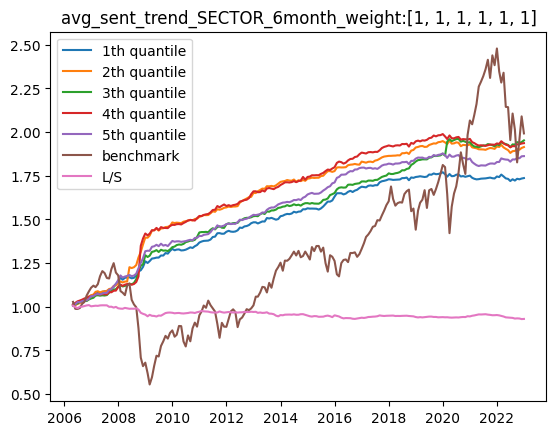

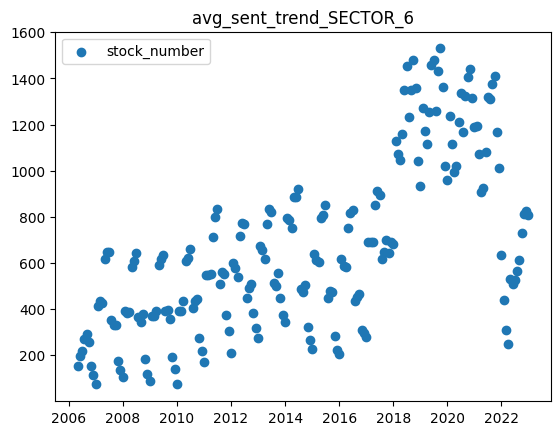

{'annual return': -0.004292559317897959, 'sharp ratio': -1.5565116519619042, 'alpha': -0.015241188445263091, 'p-value of alpha': 2.5109732688873873e-128, 'drawdown': -0.07922030771198996}
{'annual return': array([0.03350156, 0.03952354, 0.04074639, 0.04024531, 0.03782014]), 'sharp ratio': array([0.96555552, 0.9120986 , 1.08090344, 0.61681793, 1.07222743]), 'alpha': [-0.012374450136447591, -0.012025867404505565, -0.011970230978675434, -0.012523118486140709, -0.012133261691184508], 'p-value of alpha': [4.1856377024133827e-78, 3.564024020624857e-54, 4.49860554167628e-62, 5.31279772882019e-36, 4.343207042434871e-70], 'drawdown': [-0.02844556642865992, -0.0362657992711547, -0.02446813021379257, -0.038093026050607826, -0.038425057684343344]}


In [28]:
import sys
import os
if __name__ == '__main__':
    factors = ['avg_sent_trend']
    times = [6]
    for i in factors:
        for j in times:
            portfolio = global_singal_factor_protfolio(periods=j, weight=[1] * j, tag=['SECTOR'], factors=[i])
            portfolio.run()
            # fw = open("./data/"+str(portfolio.factors[0])+""+str(portfolio.tag[0])+""+str(portfolio.periods)+"month1"+".txt", 'w') 
            #这里平时print("test")换成下面这行，就可以输出到文本中了
            # fw.write(str(portfolio.ls_evaluation))
            # fw.write("\n")
            # fw.write(str(portfolio.quantile_evaluation))
            # fw.write("\n")
            # fw.write("\n")
            print(portfolio.ls_evaluation)
            print(portfolio.quantile_evaluation)